In [2]:
using Pkg
Pkg.activate("..")
include("../src/GasNetModel.jl")
using .GasNetModel, ModelingToolkit, Interpolations, DataFrames, CSV, Plots

  Activating project at `~/github/GasNetModel.jl`


In [3]:
# create a GasInfo, a collection of Dataframes that contains the info about pipes and substations, etc.
ginfo = GasInfo();

In [4]:
# create the model (1st execution time is always a bit long)
@time @mtkcompile sys = GasSystem(ginfo = ginfo, dx=10_000);

 28.226113 seconds (42.30 M allocations: 2.051 GiB, 5.12% gc time, 96.30% compilation time: 42% of which was recompilation)


In [5]:
# GasSystem.q_nodal must be explicitly defined here constant withdrawals|injections
function GasNetModel.q_nodal(i,t)
    ginfo.nodes.initial_nodal_flow[i] 
end

In [6]:
# create the ODE problem (1st execution time is always a bit long)
@time prob = ODEProblem(sys, Dict(), (0, 10_000), saveat=0:100:10_000);

 23.015097 seconds (33.40 M allocations: 1.587 GiB, 2.28% gc time, 94.84% compilation time: 29% of which was recompilation)


In [7]:
# solve it
@time sol = solve(prob);

 10.648121 seconds (27.34 M allocations: 1.402 GiB, 5.27% gc time, 99.61% compilation time)


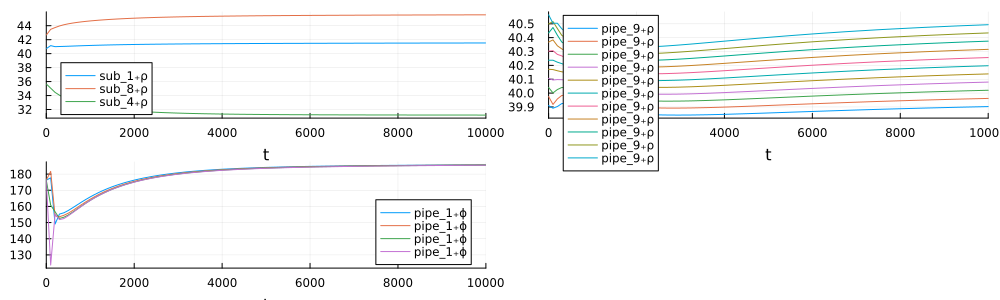

In [8]:
# check solution
plot(sol, idxs=sys.sub_1.ρ)
plot!(sol, idxs=sys.sub_8.ρ)
p1 = plot!(sol, idxs=sys.sub_4.ρ)
p2 = plot(sol, idxs=sys.pipe_9.ρ) # as expected identically seperated asymptotically
p3 = plot(sol, idxs=sys.pipe_1.ϕ) # as expected identically asymptotically
plot(p1, p2, p3, size=(1000,300))

In [ ]:
# let's now use more complex patterns
function GasNetModel.q_nodal(i,t)
    if i != 1
        return ginfo.nodes.initial_nodal_flow[i] * (1 + 0.2*sin(t/1000+ 50i))
    else
        return t > 10_000 && t < 15_000 ? 0.0 : ginfo.nodes.initial_nodal_flow[i] * (1 + sin(t/1000+ 50i))
    end
end

# the end the previous simulation can be used as initial conditions as follow
prob = ModelingToolkit.remake(prob; u0 = sol.u[end]);
@time sol = solve(prob);

In [ ]:
# check solution
plot(sol, idxs=sys.sub_1.ρ)
plot!(sol, idxs=sys.sub_2.ρ)
plot!(sol, idxs=sys.sub_4.ρ)

In [ ]:
# or with historical data
df = DataFrame(CSV.File("../data/nodal_mass_flow_bc.csv", skipto=3,header=2))
flows = [eval(Meta.parse("LinearInterpolation(df.var\"time\", df.var\"$(i)\")")) for i=1:13];

function GasNetModel.q_nodal(i,t)
    flows[i](t)
end
@time prob = ODEProblem(sys, Dict(), (0, 300_000), saveat=0:1000:300_000);

In [ ]:
# solve it
@time sol = solve(prob);

In [ ]:
# check solution
plot(sol, idxs=sys.sub_1.ρ)
plot!(sol, idxs=sys.sub_2.ρ)
plot!(sol, idxs=sys.sub_4.ρ)

In [ ]:
linepack = GasNetModel.compute_linepack(ginfo, sys, sol, 10_000)
plot(sol.t, linepack)